### Multi-bandit 

1. 문제: k개의 팔을 가진 슬롯머신을 돌리면서 가장 reward를 많이 얻는 방향으로 학습하자.
2. 조건
    - state: 없음
    - action: i번째 팔을 작동
    - reward: 기계 내부적인 값 + N(0, 1)
3. 학습 목표
    - bandit algorithm 이해하기
         - $\epsilon$-greedy
         - Optimistic initial values
         - UCB
         - Gradient bandit

## TODO
1. ucb, bandit 로직 합치는거 수정하기.
2. gradient bandit algorithm 구현하기 
3. epsilon, greedy, ucb 비교하기

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [97]:
class Bandit:
    
    def __init__(self, k_arms, true_reward, ucb):
        self.nA = k_arms
        self.true_reward = true_reward
        self.q_true = []
        self.ucb = ucb
        self.time = 1
        self.counter = np.ones(self.nA)
        
        for i in range(0, self.nA):
            self.q_true.append(np.random.randn() + self.true_reward)
            
    def step(self, action):
        reward = np.random.randn() + self.q_true[action]
        if self.ucb:
            self.time += 1
            self.counter[action] += 1
#             return reward, self.counter[action]
        return reward

In [98]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn():
        A = np.ones(nA) * epsilon / nA
        best_action = np.argmax(Q)
        A[best_action] += (1.0 - epsilon)
        return np.random.choice(nA, p=A)
    return policy_fn

In [99]:
def sarsa(env, num_episodes, true_action, epsilon=0, step_size=0.1, ucb_param=2):
    Q = np.zeros(env.nA)
    reward_sum = np.zeros(env.nA)    
    policy = make_epsilon_greedy_policy(Q, epsilon, env.nA)
    
    best_actions = [0]
    for i_episode in range(num_episodes):
        if epsilon:
            action = policy()
        if ucb_param:
            action = np.argmax(Q + ucb_param * (np.sqrt(np.log(env.time) / env.counter)))
        if action == true_action:
            best_actions.append(best_actions[-1] + 1)
        else:
            best_actions.append(best_actions[-1])
        reward = env.step(action)
        Q[action] += step_size * (reward - Q[action])
        reward_sum[action] += reward
    
    return Q, reward_sum, best_actions

In [100]:
# bandit이랑 sarsa랑 ucb가 겹치는데 어떻게 하나로 줄이지?
env = Bandit(10, 0, True)
true_best_action = np.argmax(env.q_true)
Q, reward_sum, best_actions = sarsa(env, 1000, true_best_action, epsilon=0, step_size=0.1, ucb_param=2)

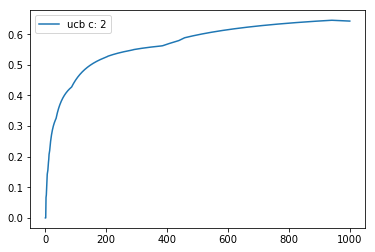

In [106]:
best_actions_percentage = [j / (float(i + 1) * num_iterations) for i, j in enumerate(best_actions_sum[1:])]
plt.plot(np.arange(1, 1001), best_actions_percentage, label='ucb c: 2')
plt.legend()
plt.show()

### Figure 2.3

- **Optimistic Initial Values** <br>
exploration을 위한 매우 간단한 방법이다. 주로 $Q$를 0으로 초기화했는데 이렇게 할 경우에 실제 방문하기 전까지는 해당 state가 아무 쓸모가 없어진다. (*greedy하게 움직일 경우에 실제 방문 안 할 가능성도 높다.*) <br><br>그래서, 약간의 trick으로 초기값을 높게 주게 되면 모든 state에 대해 방문하도록 유도할 수 있다! 대신, 일시적으로 exploration을 하게 끔 하는 것이므로 non-stationary한 경우에는 큰 효과를 기대하기 어렵다. 

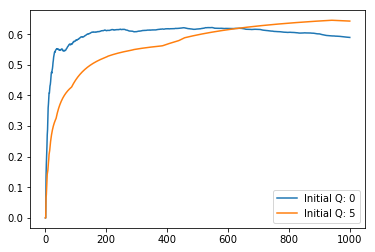

In [67]:
init_Q = [0, 5]
epsilon = [0.1, 0]
env = Bandit(10, 0, False)
num_episodes = 1000
num_iterations = 10

true_best_action = np.argmax(env.q_true)
# estimated_best_action = np.argmax(Q)
for q, eps in zip(init_Q, epsilon):
    best_actions_sum = []
    for k in range(num_iterations):
        Q, reward_sum, best_actions = sarsa(env, num_episodes, true_best_action, eps, ucb=False)
        best_actions_sum.append(best_actions)
    best_actions_sum = np.sum(best_actions_sum, axis=0)
    best_actions_percentage = [j / (float(i + 1) * num_iterations) for i, j in enumerate(best_actions_sum[1:])]
    plt.plot(np.arange(1, num_episodes + 1), best_actions_percentage, label='Initial Q: {}'.format(q))
plt.legend()
plt.show()